# 04 - Lasso + Neural Network Hybrid Model

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os


##  Load and Prepare Data

In [2]:
df = pd.read_csv("../../data/processed/cleaned_framingham.csv")
X = df.drop(columns="TenYearCHD")
y = df["TenYearCHD"]


## Feature Selection with Lasso

In [3]:
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

selected_features = X.columns[lasso.coef_ != 0]
print(f"Selected features: {list(selected_features)}")

X_selected = X[selected_features]


Selected features: ['male', 'age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


In [4]:

# 🕵️ Show which features were dropped by Lasso
all_features = set(X.columns)
selected_features = set(selected_features)
dropped_features = all_features - selected_features

print("✅ Selected Features:", sorted(selected_features))
print("❌ Dropped Features:", sorted(dropped_features))


✅ Selected Features: ['BMI', 'age', 'cigsPerDay', 'diaBP', 'glucose', 'heartRate', 'male', 'sysBP', 'totChol']
❌ Dropped Features: ['BPMeds', 'currentSmoker', 'diabetes', 'education', 'prevalentHyp', 'prevalentStroke']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


## Define Neural Network Model

In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)


## Train the Model

In [7]:
model = SimpleNN(X_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_history = []
epochs = 100
for epoch in range(epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 0.7346
Epoch 10: Loss = 0.4388
Epoch 20: Loss = 0.4004
Epoch 30: Loss = 0.3906
Epoch 40: Loss = 0.3805
Epoch 50: Loss = 0.3762
Epoch 60: Loss = 0.3730
Epoch 70: Loss = 0.3706
Epoch 80: Loss = 0.3685
Epoch 90: Loss = 0.3670


## Evaluate the Model

In [8]:
model.eval()
with torch.no_grad():
    predictions = torch.sigmoid(model(X_test_tensor)).round()
    acc = accuracy_score(y_test_tensor.numpy(), predictions.numpy())
    print(f"Test Accuracy: {acc:.4f}")


Test Accuracy: 0.8402


In [9]:

from sklearn.metrics import mean_squared_error

# 🧮 Mean Squared Error
mse = mean_squared_error(y_test_tensor.numpy(), predictions.numpy())
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")


📉 Mean Squared Error (MSE): 0.1598


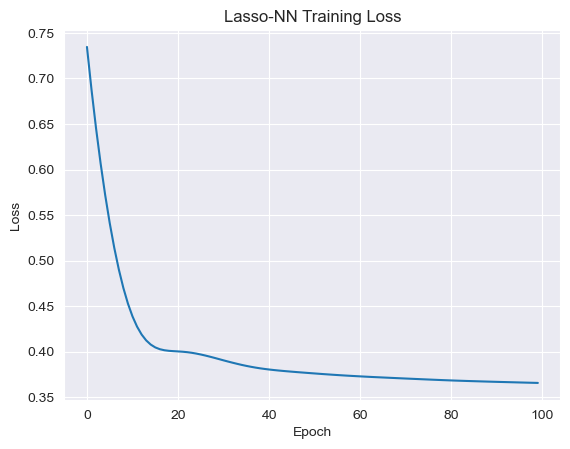

In [10]:
os.makedirs("../../models", exist_ok=True)
torch.save(model.state_dict(), "../models/lasso_nn_model.pt")

plt.figure()
plt.plot(loss_history)
plt.title("Lasso-NN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
os.makedirs("../../results/figures", exist_ok=True)
plt.savefig("../results/figures/lasso_nn_loss.png")
plt.show()


In [11]:
pd.DataFrame({
    "Prediction": predictions.numpy().flatten(),
    "Actual": y_test_tensor.numpy().flatten()
}).head()


,Prediction,Actual
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
